Load dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
from source.dataset import Dataset
from source.utils import get_unique_artists, get_unique_genres

path = 'data/dataset.csv'

data = Dataset(pd.read_csv(path, index_col=0))

Plotting various columns vs popularity

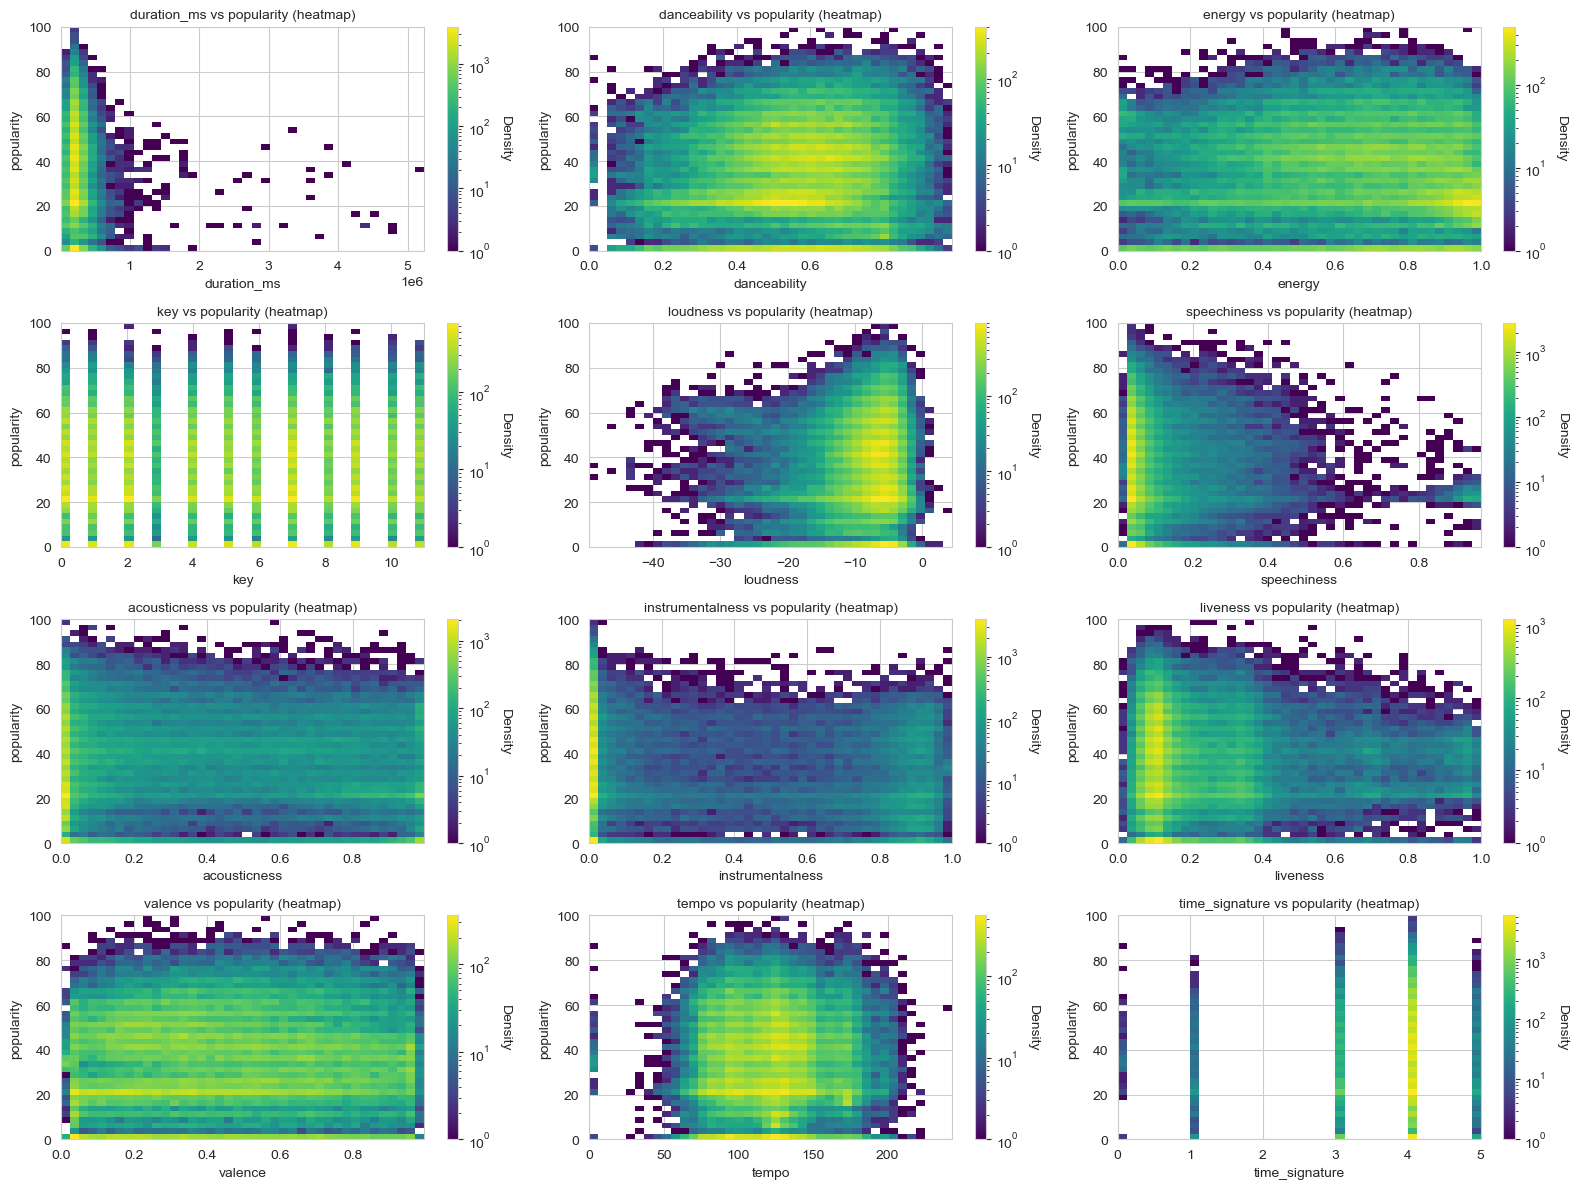

In [2]:
df = data.df

columns = ["duration_ms", "danceability", "energy", "key", "loudness",
           "speechiness", "acousticness", "instrumentalness", "liveness",
           "valence", "tempo", "time_signature"]
target = "popularity"

fig, axes = plt.subplots(4, 3, figsize=(16, 12))
axes = axes.flatten()
for i, col in enumerate(columns):
    ax = axes[i]
    hm = ax.hist2d(df[col], df[target], bins=40, cmap='viridis', norm=LogNorm())
    ax.set_title(f"{col} vs {target} (heatmap)", fontsize=10)
    ax.set_xlabel(col)
    ax.set_ylabel(target)
    bar = plt.colorbar(hm[3], ax=ax)
    bar.set_label("Density", rotation=270, labelpad=15)
plt.tight_layout()
plt.show()

The distribution of track popularity

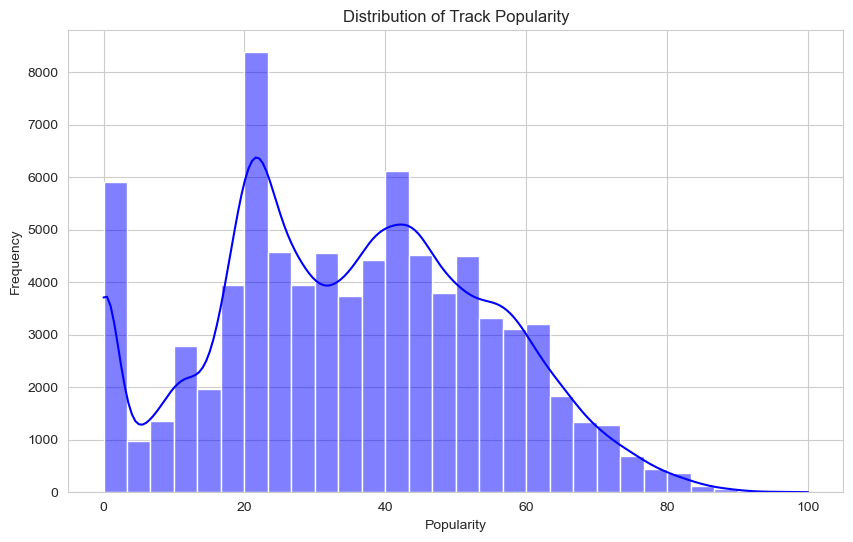

In [3]:
plt.figure(figsize=(10, 6))
sns.histplot(df['popularity'], bins=30, kde=True, color='blue')
plt.title('Distribution of Track Popularity')
plt.xlabel('Popularity')
plt.ylabel('Frequency')
plt.show()

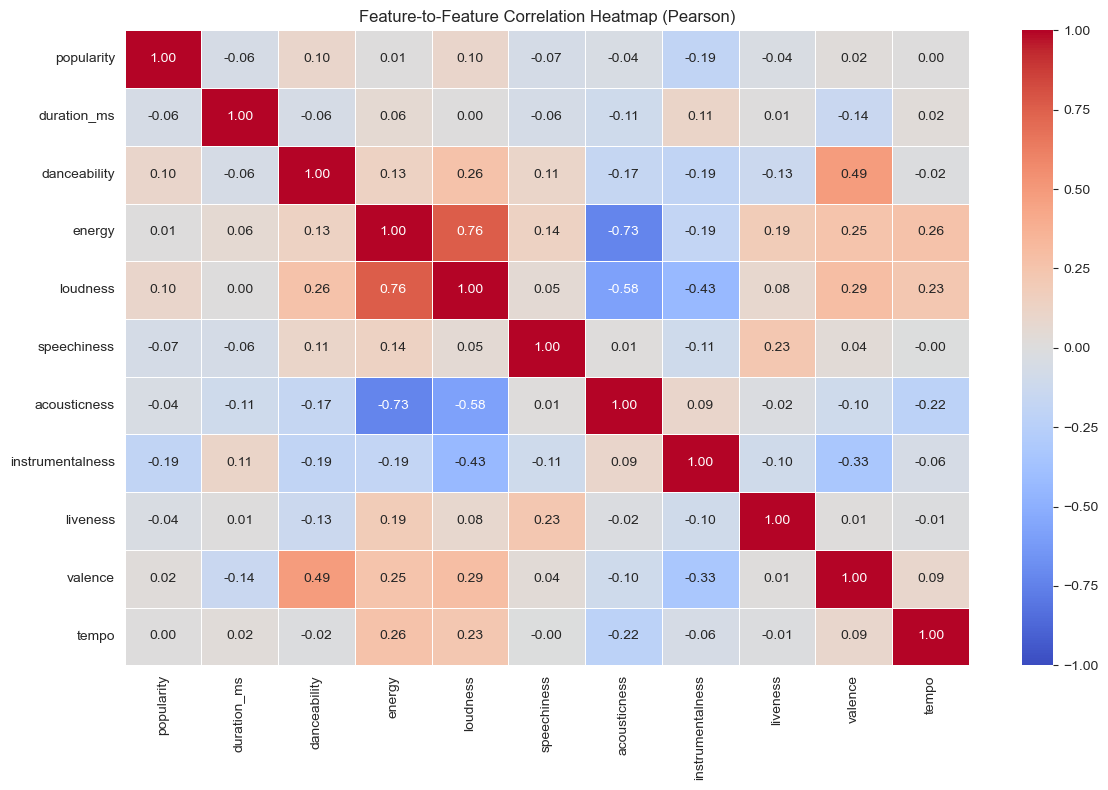

In [4]:
features = [
    'popularity','duration_ms','danceability','energy','loudness','speechiness',
    'acousticness','instrumentalness','liveness','valence','tempo'
]
features = [c for c in features if c in df.columns]

sub = df[features].apply(pd.to_numeric, errors='coerce')
for c in features:
    sub[c] = sub[c].fillna(sub[c].median())

corr = sub.corr(method='pearson')

plt.figure(figsize=(12, 8))
sns.heatmap(corr, cmap='coolwarm', center=0, vmin=-1, vmax=1, annot=True, fmt='.2f', linewidths=0.5)
plt.title('Feature-to-Feature Correlation Heatmap (Pearson)')
plt.tight_layout()
plt.show()

Top 3 strongest positive correlations:
·Loudness ↔ Energy — louder tracks tend to be more energetic.
·Valence ↔ Danceability — happier-sounding tracks tend to be more danceable.
·Valence ↔ Loudness — happier-sounding tracks tend to be louder.
    
From correltion heatmap, popularity does not have significant correlation with other features.

The relationship between energy and loudness

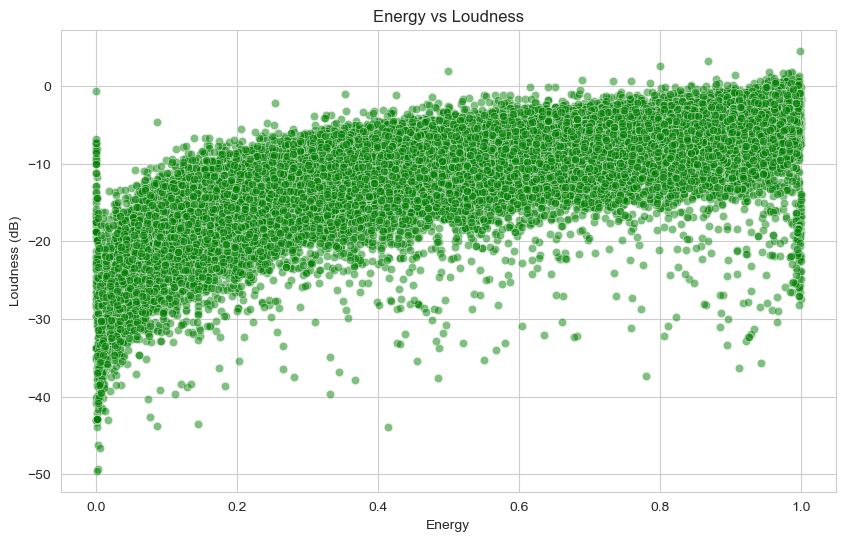

In [5]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='energy', y='loudness', data=df, alpha=0.5, color='green')
plt.title('Energy vs Loudness')
plt.xlabel('Energy')
plt.ylabel('Loudness (dB)')
plt.show()

Top 10 most frequent artists

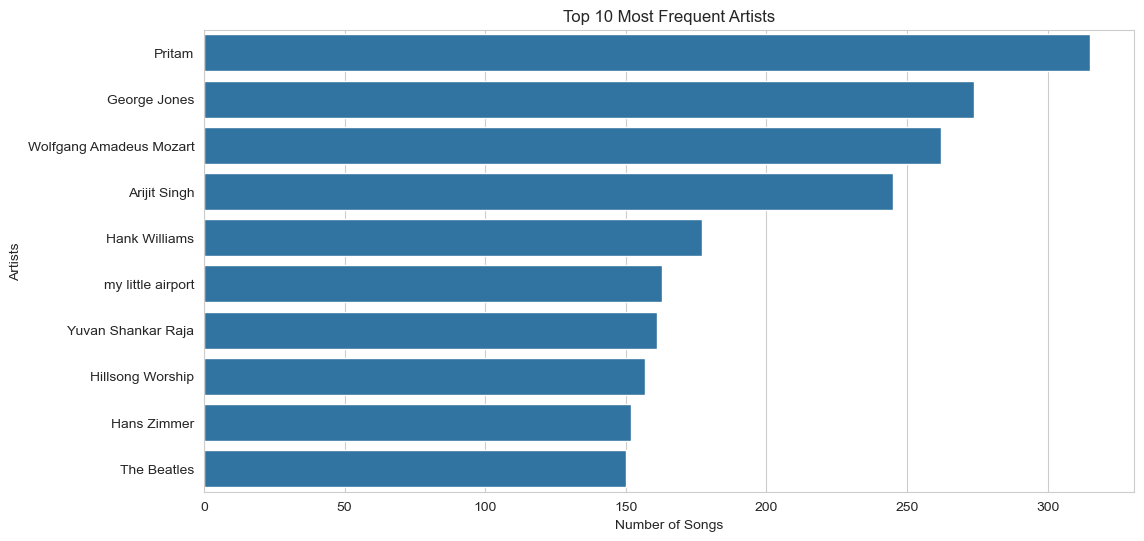

In [6]:
artists = get_unique_artists(data)
artist_dict = {artist: 0 for artist in artists}
for artist in df['artists']:
    for a in artist:
        artist_dict[a] += 1
top_artists = sorted(artist_dict.items(), key=lambda item: item[1], reverse=True)[:10]

# plot the top 10 artists
plt.figure(figsize=(12, 6))
sns.barplot(x=[artist[1] for artist in top_artists], y=[artist[0] for artist in top_artists])
plt.title('Top 10 Most Frequent Artists')
plt.xlabel('Number of Songs')
plt.ylabel('Artists')
plt.show()

Top 15 Most Popular Genres

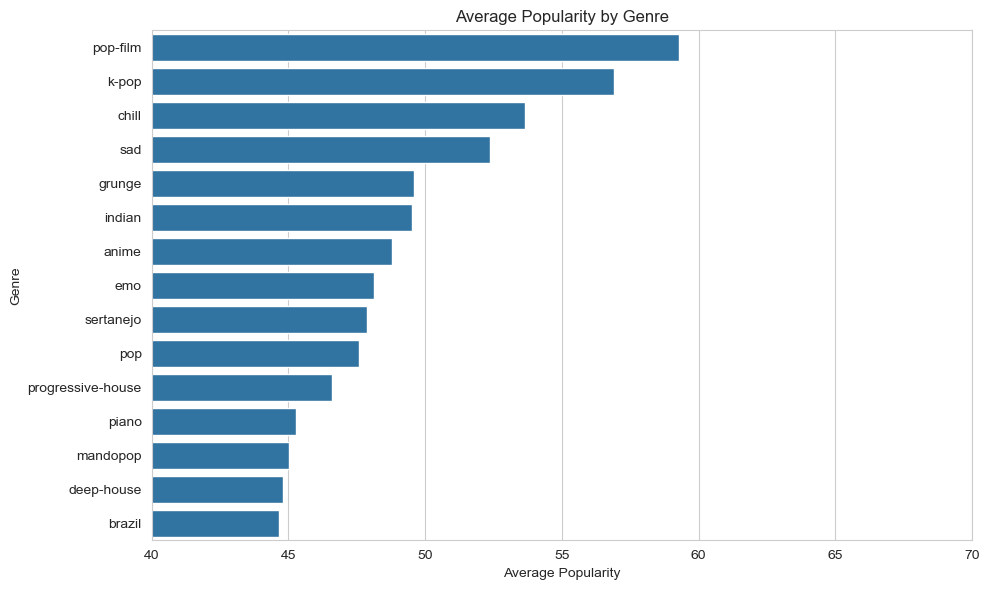

In [7]:
df = data.raw

mean_pop = df.groupby('track_genre')['popularity'].mean().sort_values(ascending=False)
top = mean_pop.head(15)

plt.figure(figsize=(10, 6))
sns.barplot(x=top.values, y=top.index, color='tab:blue')
plt.title('Average Popularity by Genre')
plt.xlabel('Average Popularity'); plt.ylabel('Genre')
plt.xlim(40, 70)
plt.tight_layout()
plt.show()

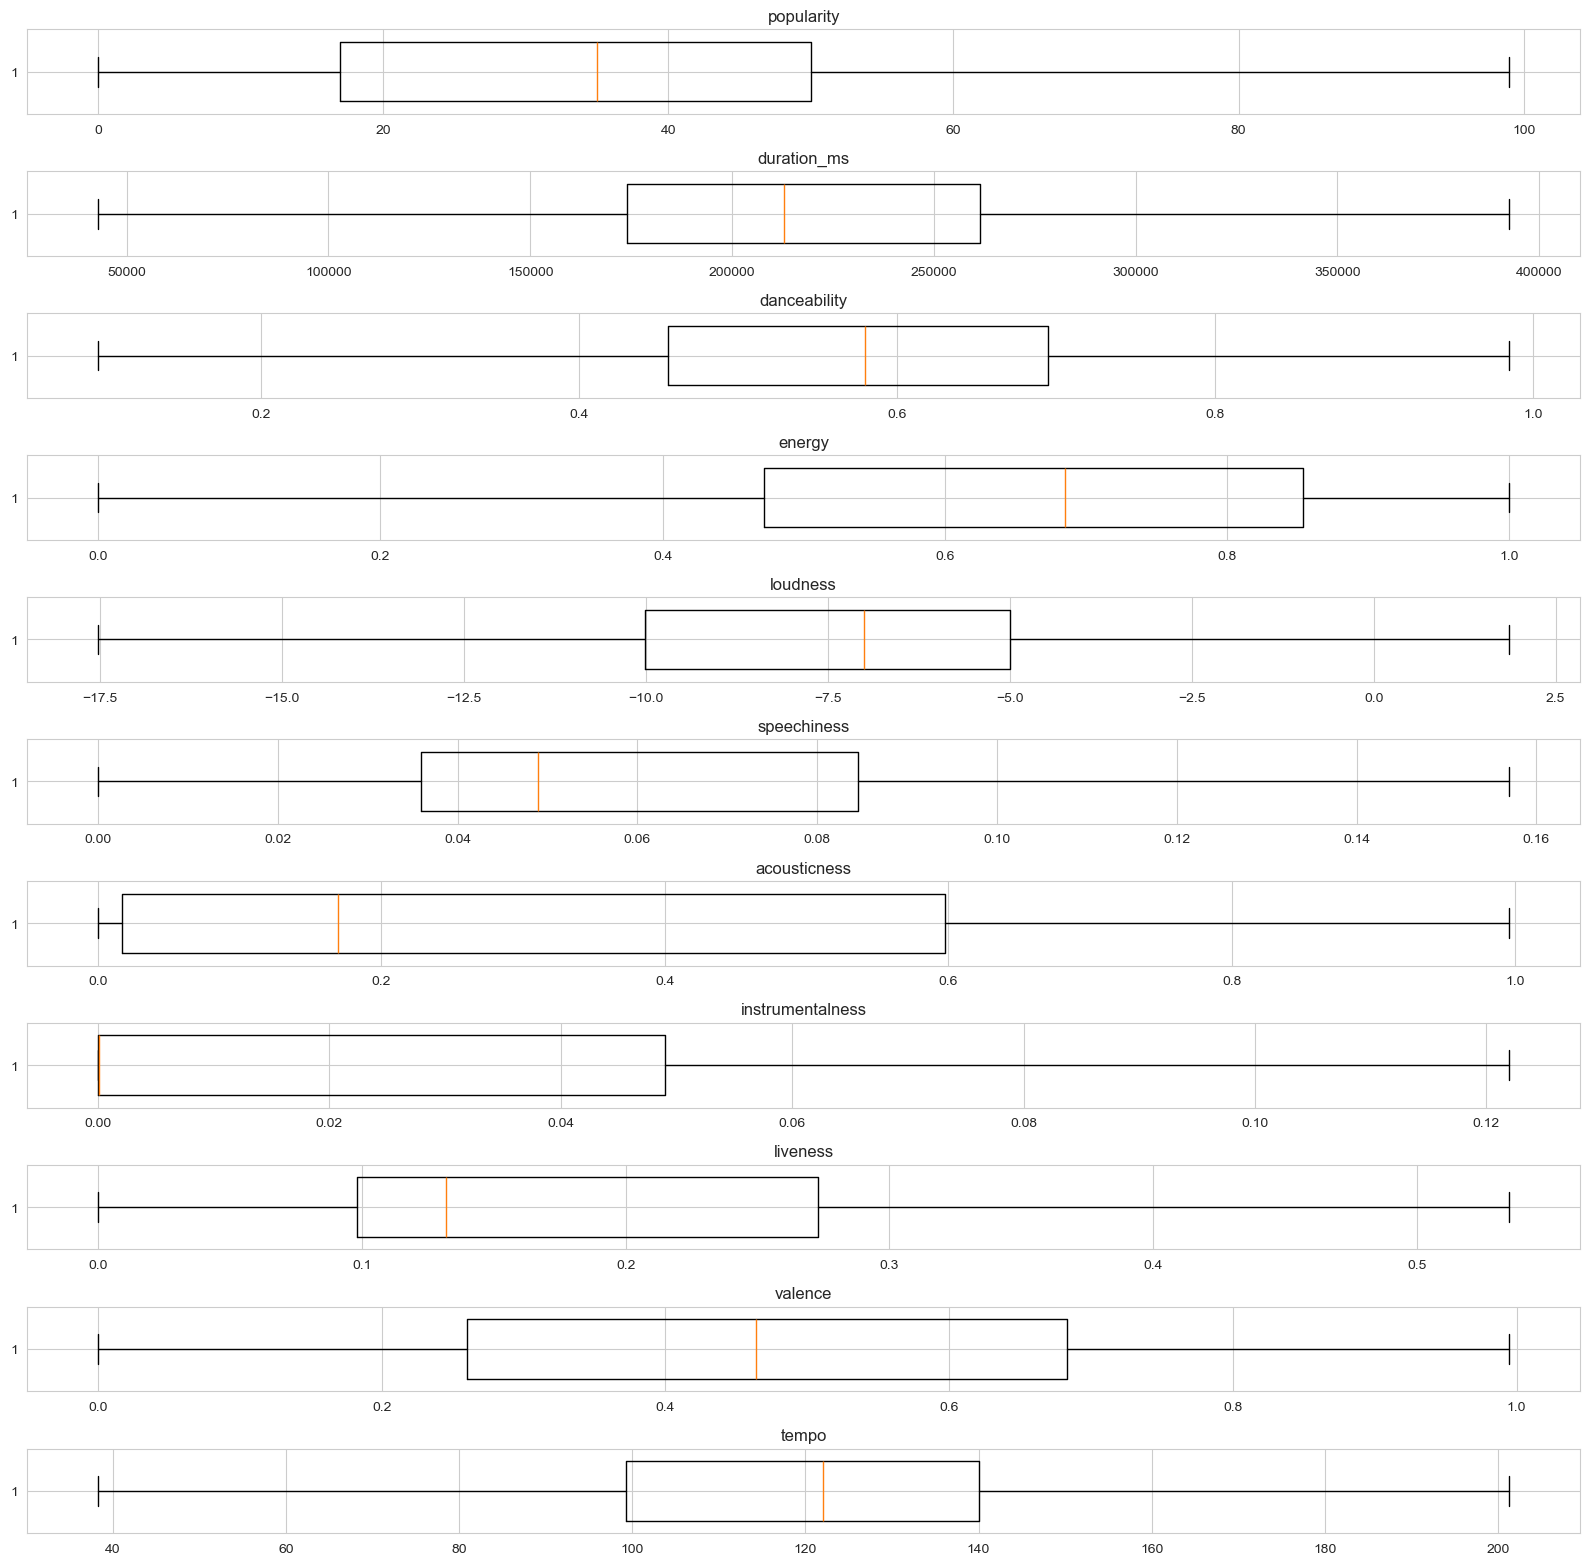

In [8]:
num_features = data.numerical_features

fig, axes = plt.subplots(len(num_features), 1, figsize=(16, 16))
axes = axes.flatten()
for i, col in enumerate(num_features):
    axes[i].boxplot(df[col], orientation='horizontal', widths=0.7, showfliers=False)
    axes[i].set_title(col)
plt.tight_layout(rect=(0, 0, 1, 0.985))
plt.show()

In [9]:
def plot_genre_boxplots(genres):
    for genre in genres:
        assert genre in get_unique_genres(data)
        fig, axes = plt.subplots(len(num_features), 1, figsize=(16, 16))
        axes = axes.flatten()
        fig.suptitle(f'{genre}')
        for i, col in enumerate(num_features):
            axes[i].boxplot(df[col], positions=[0.5], orientation='horizontal', widths=0.7, showfliers=False, tick_labels=["all"])
            axes[i].boxplot(df[df['track_genre'] == genre][col], positions=[1.5], orientation='horizontal', widths=0.7, showfliers=False, tick_labels=[genre])
            axes[i].set_title(col)
        plt.tight_layout(rect=(0, 0, 1, 0.985))
        plt.savefig(f'figures/{genre}_boxplot.png')
        plt.close()

In [10]:
def compare_targets_and_recommendations(targets, recommendations):
    fig, axes = plt.subplots(len(num_features), 1, figsize=(16, 16))
    axes = axes.flatten()
    target = [data.get_track_id(artists, track_name) for artists, track_name in targets]
    recommendation = [data.get_track_id(artists, track_name) for artists, track_name in recommendations]
    for i, col in enumerate(num_features):
        axes[i].boxplot(df[col], positions=[0.5], orientation='horizontal', widths=0.7, showfliers=False, tick_labels=[None])
        scatter_x = list(data.df[col][recommendation])
        scatter_y = [0.5]*len(recommendation)
        scatter_c = list(range(1, 1+len(recommendation)))
        axes[i].scatter(data.df[col][target], [0.5]*len(target), color='red')
        axes[i].scatter(scatter_x, scatter_y, c=scatter_c, cmap='Set2')
        axes[i].set_title(col)
    fig.legend(['all', 'target', 'recommendation'])
    plt.tight_layout(rect=(0, 0, 1, 0.985))
    plt.savefig(f'figures/{targets[0]}_{recommendations[0]}_boxplot.png')
    plt.close()

In [11]:
targets = [("Adele", "Rolling in the Deep"),
           ("Bruno Mars", "Just the Way You Are")]
recommendations = [("Bastille;Marshmello", "Happier"),
                   ("Anderson .Paak;Bruno Mars;Silk Sonic", "Leave The Door Open"),
                   ("BloodPop®;Hailee Steinfeld", "Capital Letters"),
                   ("Bruno Mars", "Locked out of Heaven"),
                   ("Selena Gomez", "Back To You - From 13 Reasons Why – Season 2 Soundtrack")]
compare_targets_and_recommendations(targets, recommendations)

In [12]:
targets = [("Adele", "Rolling in the Deep"),
           ("Bruno Mars", "Just the Way You Are")]
recommendations = [("Adele", "Can I Get It"),
                   ("Adele", "Set Fire to the Rain"),
                   ("Adele", "Oh My God"),
                   ("Adele", "Water Under the Bridge"),
                   ("Adele", "Chasing Pavements")]
compare_targets_and_recommendations(targets, recommendations)